## 1.Importing Libraries

In [3]:
import sys
import os

import gc
import warnings

from subprocess import check_output

from datetime import datetime
from glob import glob
from tqdm import tqdm

import numpy as np
from numpy.linalg import svd
import scipy.stats as stats
from scipy.sparse.linalg import svds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as se
from itertools import combinations


from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
from tensorflow.keras.utils import plot_model, Progbar


from surprise import Dataset, NormalPredictor, Reader, SVD

from mlxtend.frequent_patterns.fpgrowth import fpgrowth
from mlxtend.preprocessing import TransactionEncoder


import multiprocess
from functools import partial

from ipynb.fs.full.metrics import (
    hit_rate_at_k_score,
    mean_average_precision_at_k_score,
    ndcg_score_at_k,
)

from sklearn.model_selection import train_test_split

2023-01-06 10:16:22.145905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 1 to 6040
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ground_truth  1188 non-null   object
 1   prediction    1188 non-null   object
dtypes: object(2)
memory usage: 27.8+ KB


In [4]:
# se.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
# Set pandas view options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 30)
warnings.filterwarnings("ignore")
# %matplotlib inline

In [5]:
# The goal of a competition is to predict which previously purchased products will be in a user’s next order.

# 2.Loading Data

In [6]:
processed_data_path = "/Users/Artem_Boltaev/Documents/EPAM Projects/6. RecSys_course/source_code/recsys_course_epam/data/processed/instacart-market-basket-analysis-processed"
print(check_output(["ls", processed_data_path]).decode("utf8"))

df_test.csv
df_test_mod.csv
df_train.csv
df_train_mod.csv



In [7]:
df_train = pd.read_csv(processed_data_path + "/df_train.csv")
df_test = pd.read_csv(processed_data_path + "/df_test.csv")

df_train_mod = pd.read_csv(processed_data_path + "/df_train_mod.csv")
df_test_mod = pd.read_csv(processed_data_path + "/df_test_mod.csv")

# 3.Data Preprocessing

In [8]:
df = pd.concat([df_train, df_test], axis=0)
df.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


# 4.Model Building

In [9]:
# A bunch of functions to help us with the model

# normalizing scores to 1
def normalization_ndcg(y_true, y_pred):

    y_true_norm = []
    y_pred_norm = []

    for i in range(len(y_true)):
        y_true_norm.append([x / x for x in y_true[i]])

    for i in range(len(y_pred)):
        y_pred_norm_row = []
        for el in y_pred[i]:
            if el in y_true[i]:
                score = 1
            else:
                score = 0
            y_pred_norm_row.append(score)

        y_pred_norm.append(y_pred_norm_row)

    y_pred_norm = np.array(y_pred_norm)
    y_true_norm = np.array(y_true_norm)

    y_true_norm = y_true_norm.astype(int)
    y_pred_norm = y_pred_norm.astype(int)

    return y_true_norm, y_pred_norm


def get_scores(y_true, y_pred, k):
    y_true = y_true["y_true"].apply(pd.Series).to_numpy()
    y_pred = y_pred["y_pred"].apply(pd.Series).to_numpy()

    hit_rate_at_k = hit_rate_at_k_score(y_true, y_pred, k)
    mean_average_precision_at_k = mean_average_precision_at_k_score(
        y_true, y_pred, k)

    # normalizing scores to 1
    y_true_norm, y_pred_norm = normalization_ndcg(y_true, y_pred)
    ndcg_at_k = ndcg_score_at_k(y_true_norm, y_pred_norm, k, gains="linear")

    print(
        "hit_rate_at_k",
        hit_rate_at_k,
        "\n" "mean_average_precision_at_k",
        mean_average_precision_at_k,
        "\n" "ndcg_at_k",
        ndcg_at_k,
    )


In [10]:
n_users_for_rec = 1000
# n_users_for_rec = df_test['user_id'].unique()

y_true = (
    df_test.groupby("user_id")["product_id"]
    .agg(lambda x: list(x))
    .reset_index(name="y_true")
).iloc[:n_users_for_rec]
y_true


,user_id,y_true
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."
...,...,...
995,1557,"[23288, 46521, 37710, 21195, 17168, 5258]"
996,1559,"[34610, 21477, 9106, 7695, 42052, 24993, 1999,..."
997,1562,"[38739, 37931, 41149, 26769, 42342, 2380, 1541..."
998,1565,"[35629, 21927, 18908]"


In [11]:
n_rec = 5

n_users_train = df_train_mod["user_id"].max()
n_products_train = df_train_mod["product_id"].max()

test_user_id_list = y_true["user_id"].unique()
train_product_id_list = df_train_mod["product_id"].unique()


## 4.1 Most popular recommender

In [11]:
# most popular products
cnt_product = df_train["product_id"].value_counts().reset_index().head(20)
cnt_product.columns = ["product_id", "frequency_count"]
cnt_product.sort_values("frequency_count", ascending=False, inplace=True)
cnt_product


,product_id,frequency_count
0,24852,472565
1,13176,379450
2,21137,264683
3,21903,241921
4,47209,213584
5,47766,176815
6,47626,152657
7,16797,142951
8,26209,140627
9,27845,137905


In [12]:
y_pred_most_popular = y_true["user_id"]
y_pred_most_popular = pd.DataFrame(y_pred_most_popular)
y_pred_most_popular["y_pred"] = 24852
y_pred_most_popular

,user_id,y_pred
0,1,24852
1,2,24852
2,5,24852
3,7,24852
4,8,24852
...,...,...
995,1557,24852
996,1559,24852
997,1562,24852
998,1565,24852


### 4.1.1 Evaluation

In [13]:
get_scores(y_true, y_pred_most_popular, k=3)

hit_rate_at_k 0.127 
mean_average_precision_at_k 0.127 
ndcg_at_k 0.05777906236316229


## 4.2 SVD
#performs inference for users batches to overcome memory issue

In [12]:
# A bunch of functions to help us with the model


def cosine_similarity(a, b):
    """
    This function will calculate the cosine similarity between two vectors
    """
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def get_similarities(mat, id_):
    """
    This function will use the cosine similarity function to generate a similarity
    dictionary assocaited to an id the user passes in. The similarity dictionary will
    have the ids as the keys and the similarity in comparison to the user input id as
    the values.

    params:
        mat (List -> List) : A 2-D array assocaited to either the user / item matrix
                             after SVD
        id_ (Integer) : The id of the user / item you want to find similarities for.
                        The id must be in the range of the input matrix shape.

    returns:
        This function will return the similarity dictionary ordered by the values in
        descending order.

    example:
        mat = np.asarray([
            [2,3,4],
            [6,5,3],
            [5,3,2]
        ])
        id_ = 2
        get_similarities(mat, id_)
    """
    # create similarity hashmap, keys are ids and values are similarities
    sim_dct = {}
    for col in range(0, mat.shape[1]):
        sim = cosine_similarity(mat[:, id_], mat[:, col])
        sim_dct[col] = sim

    # sort dictionary based on similarities
    sim_dct = {
        k: v for k, v in sorted(sim_dct.items(), key=lambda item: item[1], reverse=True)
    }
    return sim_dct


def recommend(mat, id_, n_recs):
    """
    This function will get the top n recommendations assocaited to an id.

    params:
        mat (List -> List) : A 2-D array assocaited to either the user / item matrix
                             after SVD
        id_ (Integer) : The id of the user / item you want to find similarities for.
                        The id must be in the range of the input matrix shape.
        n_recs (Integer) : The number of recommendations you want.

    returns:
        This function will return a list of ids most similar to the input id you passed.
    """
    sim_dct = get_similarities(mat, id_)
    similar_ids = list(sim_dct.keys())[1: n_recs + 1]
    return similar_ids


# A function to get the top n recommendations for a user scipy SVD
def recommend_products(preds_df, userID, num_recommendations=5):

    user_row_number = userID - 1  # UserID starts at 1, not 0

    sorted_user_predictions = (
        preds_df.iloc[user_row_number]
        .sort_values(ascending=False)
        .iloc[:num_recommendations]
    )

    return sorted_user_predictions.index.tolist()


# A function to get the top n recommendations for a user surprise SVD
def get_recommendations_surprise_SVD(train_product_id_list, n_rec, test_user_id_list):
    recommendations_pred = []

    for user in tqdm(test_user_id_list):
        recommendations_raiting = []
        recommendations_item = []
        for product in train_product_id_list:
            pred = algo.predict(uid=user, iid=product,
                                clip=False, verbose=False)
            recommendations_raiting.append(pred.est)
            recommendations_item.append(pred.iid)

        df = pd.DataFrame(
            {"item_id": recommendations_item, "raiting": recommendations_raiting}
        )
        df.sort_values("raiting", ascending=False, inplace=True)
        df = df.dropna()

        recommendations_pred.append(df["item_id"].to_list()[:n_rec])
    return recommendations_pred


In [13]:
# prepare rating matrix


rating_matrix = np.zeros((n_users_train, n_products_train), dtype=float)

for row in tqdm(
    df_train_mod[["user_id", "product_id",
                  "product_count_by_user"]].itertuples()
):
    rating_matrix[row[1] - 1, row[2] - 1] = row[3]

rating_matrix = pd.DataFrame(rating_matrix)


13307953it [01:28, 149873.11it/s]


In [14]:
rating_matrix.shape

(206209, 49688)

In [15]:
# SVD from surprise library

reader = Reader(rating_scale=(1, 99))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(
    df_train_mod[["user_id", "product_id", "product_count_by_user"]], reader
)

# Retrieve the trainset.
trainset = data.build_full_trainset()

# Build an algorithm, and train it.
algo = SVD()
algo.fit(trainset)


In [18]:
# SVD from scipy library
"""matrix = rating_matrix.iloc[:, :10000].values
u, s, vh = svds(matrix, k=6)

u.shape, s.shape, vh.shape

sigma = np.diag(s)
all_user_predicted_ratings = np.dot(np.dot(u, sigma), vh)


#get recommendations for scipy SVD

recommendations = []

for user in tqdm(y_true['user_id'].iloc[:n_users_train]):
    recommendations.append(recommend_products(pd.DataFrame(all_user_predicted_ratings), user, 5))"""


"matrix = rating_matrix.iloc[:, :10000].values\nu, s, vh = svds(matrix, k=6)\n\nu.shape, s.shape, vh.shape\n\nsigma = np.diag(s)\nall_user_predicted_ratings = np.dot(np.dot(u, sigma), vh)\n\n\n#get recommendations for scipy SVD\n\nrecommendations = []\n\nfor user in tqdm(y_true['user_id'].iloc[:n_users_train]):\n    recommendations.append(recommend_products(pd.DataFrame(all_user_predicted_ratings), user, 5))"

In [19]:
# get recommendations for surprise SVD
num_of_processes = 4

batches = np.array_split(test_user_id_list, num_of_processes)
pool = multiprocess.Pool(processes=num_of_processes)

result_list = pool.map(
    partial(get_recommendations_surprise_SVD,
            train_product_id_list, n_rec), batches
)

recommendations_pred_SVD = sum(result_list, [])

pool.close()


100%|██████████| 250/250 [01:58<00:00,  2.12it/s]


In [20]:
y_pred_svd = y_true["user_id"]
y_pred_svd = pd.DataFrame(y_pred_svd)
y_pred_svd["y_pred"] = pd.DataFrame(recommendations_pred_SVD).values.tolist()
y_pred_svd.head(10)

,user_id,y_pred
0,1,"[12427, 26949, 196, 10258, 32439]"
1,2,"[48733, 35417, 31651, 14874, 35595]"
2,5,"[48095, 13166, 40183, 4451, 10070]"
3,7,"[5514, 40852, 9138, 16083, 14702]"
4,8,"[48095, 49609, 34197, 32566, 1402]"
5,9,"[31720, 45035, 47765, 34246, 13128]"
6,10,"[16490, 37718, 31720, 6433, 2075]"
7,13,"[31720, 29118, 2962, 48095, 3896]"
8,14,"[29509, 6209, 23803, 45504, 8475]"
9,17,"[7350, 18534, 34270, 17762, 9292]"


### 4.2.1 Evaluation

In [21]:
get_scores(y_true, y_pred_svd, k=3)

hit_rate_at_k 0.14 
mean_average_precision_at_k 0.10458333333333335 
ndcg_at_k 0.05291890297826275


## 4.3 Neural Network

2 embedding layers for user and item and calculates the score as the dot product.

Fully-connected layers can be incorporated as well to improve the model's expressiveness

In [22]:
# A bunch of functions to help us with the model


def get_recommendations_NN(model2, df_train_mod, n_rec, test_user_id_list):
    recommendations_pred = []
    items_pred = np.array(df_train_mod["product_id"].unique())

    for user in tqdm(test_user_id_list):

        user_pred = np.array([user for i in range(len(items_pred))])

        predictions = model2.predict([user_pred, items_pred], verbose=0)
        predictions = np.array([a[0] for a in predictions])

        df = pd.DataFrame({"item_id": items_pred, "raiting": predictions})
        df.sort_values("raiting", ascending=False, inplace=True)
        df = df.dropna()

        recommendations_pred.append(df["item_id"].to_list()[:n_rec])

    return recommendations_pred


In [23]:
# creating product embedding path
product_input = Input(shape=[1], name="product-Input")
product_embedding = Embedding(n_products_train + 1, 5, name="product-Embedding")(
    product_input
)
product_vec = Flatten(name="Flatten-products")(product_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(
    n_users_train + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([product_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation="relu")(conc)
fc2 = Dense(32, activation="relu")(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, product_input], out)
model2.compile("adam", "mean_squared_error")


2022-12-14 11:55:23.584439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
n_epochs = 3
# steps_per_epoch = 400000

if os.path.exists("regression_model10.h5"):
    model2 = load_model("regression_model10.h5")
else:
    history = model2.fit(
        [df_train_mod.user_id, df_train_mod.product_id],
        df_train_mod.product_count_by_user,
        epochs=n_epochs,
        steps_per_epoch=None,
        verbose=1,
        workers=4,
        use_multiprocessing=True,
    )
    model2.save("regression_model10.h5")
    plt.plot(history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [ ]:
# model2.evaluate([df_train_mod.user_id, df_train_mod.product_id], df_train_mod.product_count_by_user)


In [ ]:
predictions = model2.predict(
    [df_train_mod.user_id.head(10), df_train_mod.product_id.head(10)]
)

[
    print(predictions[i], df_train_mod.product_count_by_user.iloc[i])
    for i in range(0, 10)
]


1/1 [==============================] - 0s 380ms/step
[4.0936036] 5
[4.82366] 5
[1.0604808] 1
[1.4560084] 5
[1.9278669] 3
[3.42728] 7
[0.97217256] 5
[2.1304328] 2
[1.5382627] 3
[4.3347297] 17


[None, None, None, None, None, None, None, None, None, None]

In [167]:
recommendations_pred_NN = get_recommendations_NN(
    model2, df_train_mod, n_rec, test_user_id_list
)
recommendations_pred_NN


100%|██████████| 1000/1000 [31:32<00:00,  1.89s/it]


[[40170, 2406, 43541, 35604, 15201],
 [29447, 45298, 15201, 43541, 27845],
 [38689, 39180, 24852, 42414, 31720],
 [45298, 38689, 29447, 43541, 39180],
 [9292, 43541, 15201, 45298, 40305],
 [29447, 45504, 47909, 15201, 45298],
 [9292, 33065, 46586, 40305, 43734],
 [35604, 15201, 43541, 45298, 47909],
 [47909, 15201, 45298, 35604, 29447],
 [29447, 31720, 43394, 27845, 20082],
 [9292, 16322, 1069, 4210, 29447],
 [47909, 42414, 35604, 15657, 37184],
 [29447, 45504, 47909, 15201, 45298],
 [45504, 117, 45298, 2075, 36011],
 [29447, 39180, 45298, 27845, 21796],
 [38689, 39180, 45298, 29447, 48670],
 [45504, 1157, 37184, 13806, 13420],
 [9292, 16322, 29447, 40305, 4210],
 [32566, 34197, 29447, 19660, 9292],
 [45298, 38689, 15201, 47909, 29447],
 [9292, 20851, 1157, 46586, 36865],
 [31720, 29447, 43394, 38689, 27845],
 [29447, 45298, 32566, 47909, 15201],
 [47909, 35604, 38529, 29447, 15201],
 [39180, 38689, 24852, 45298, 28878],
 [9292, 29447, 47909, 13166, 15657],
 [45298, 15201, 43541, 9292,

In [168]:
y_pred_NN = y_true["user_id"]
y_pred_NN = pd.DataFrame(y_pred_NN)
y_pred_NN["y_pred"] = pd.DataFrame(recommendations_pred_NN).values.tolist()
y_pred_NN.head(10)


,user_id,y_pred
0,1,"[40170, 2406, 43541, 35604, 15201]"
1,2,"[29447, 45298, 15201, 43541, 27845]"
2,5,"[38689, 39180, 24852, 42414, 31720]"
3,7,"[45298, 38689, 29447, 43541, 39180]"
4,8,"[9292, 43541, 15201, 45298, 40305]"
5,9,"[29447, 45504, 47909, 15201, 45298]"
6,10,"[9292, 33065, 46586, 40305, 43734]"
7,13,"[35604, 15201, 43541, 45298, 47909]"
8,14,"[47909, 15201, 45298, 35604, 29447]"
9,17,"[29447, 31720, 43394, 27845, 20082]"


### 4.3.1 Evaluation

In [169]:
get_scores(y_true, y_pred_NN, k=3)


hit_rate_at_k 0.022 
mean_average_precision_at_k 0.012666666666666666 
ndcg_at_k 0.006352746376490272


### 4.3.2 Visualizing Neural Network

In [170]:
model2.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product-Embedding (Embedding)  (None, 1, 5)         248445      ['product-Input[0][0]']          
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         1031050     ['User-Input[0][0]']             
                                                                                            

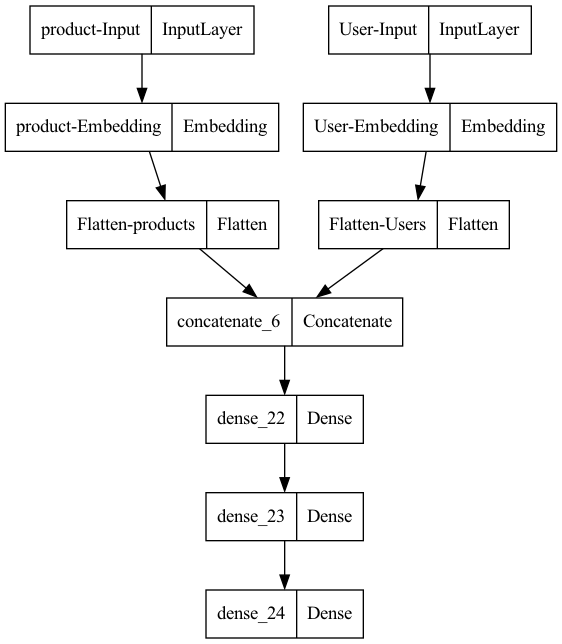

In [171]:
plot_model(model2, to_file="model.png")


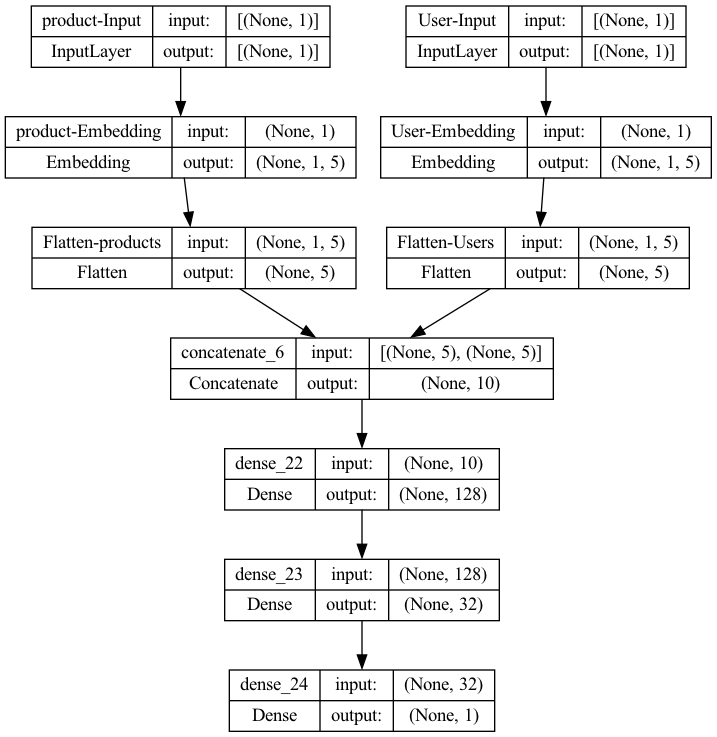

In [172]:
plot_model(model2, to_file="model_plot.png",
           show_shapes=True, show_layer_names=True)


## 4.4 Nearest Neighbor recommender
utilizing SVD embeddings and annoy library for fast neighbors search

## 4.5 ALS recommender from the implicit library

## 4.6 Gradient boosting recommender utilizing SVD embedding 

In [154]:
n_rec


5

## 4.7 The Pointwise Approach Associative Rules

In [224]:
def get_recommendations_association_rules(df_train, n_rec, user_id):

    df_ = df_train[df_train["user_id"] == user_id]

    orders_train_ = pd.DataFrame(
        df_.groupby(["order_id"])["product_id"]
        .apply(list)
        .reset_index(name="order_list")
    )

    # instantiate a transaction encoder
    my_transactionencoder = TransactionEncoder()

    # fit the transaction encoder using the list of transaction tuples
    my_transactionencoder.fit(orders_train_.order_list)

    # transform the list of transaction tuples into an array of encoded transactions
    encoded_transactions = my_transactionencoder.transform(orders_train_.order_list)

    # convert the array of encoded transactions into a dataframe
    encoded_transactions_df = pd.DataFrame(
        encoded_transactions, columns=my_transactionencoder.columns_
    )

    # compute the frequent itemsets using fpgriowth from mlxtend
    frequent_itemsets = fpgrowth(
        encoded_transactions_df,
        use_colnames=True,
        max_len=2,
        verbose=0,
    )

    if frequent_itemsets.shape[0] == 0:
        recom_list2 = [24852]
    else:
        # Compute the association rules based on the frequent itemsets
        rules = association_rules(frequent_itemsets)

        recom_list = rules.sort_values(by="support", ascending=False)[
            "antecedents"
        ].iloc[:n_rec]

        if len(recom_list) == 0:
            recom_list2 = [24852]
        else:
            recom_list2 = [list(i) for i in recom_list]
            recom_list2 = [item[0] for item in recom_list2]

    return recom_list2

In [225]:
recommendation_matrix = []

for user in tqdm(y_true["user_id"]):

    rec_ = get_recommendations_association_rules(df_train, n_rec, user)
    recommendation_matrix.append(rec_)

100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


In [232]:
y_pred_NN = y_true["user_id"]
y_pred_NN = pd.DataFrame(y_pred_NN)
y_pred_NN["y_pred"] = pd.DataFrame(recommendation_matrix).values.tolist()
y_pred_NN.head(10)


,user_id,y_pred
0,1,"[12427.0, 196.0, 10258.0, 12427.0, 10258.0]"
1,2,"[24852.0, nan, nan, nan, nan]"
2,5,"[11777.0, 26604.0, 43693.0, 43693.0, 43693.0]"
3,7,"[37602.0, 40852.0, 17638.0, nan, nan]"
4,8,"[17794.0, 17794.0, 2078.0, 23165.0, 2078.0]"
5,9,"[27966.0, 8834.0, 24341.0, 26604.0, 24341.0]"
6,10,"[30489.0, 30489.0, 28535.0, 47526.0, 28535.0]"
7,13,"[4210.0, 27086.0, 27435.0, 27435.0, nan]"
8,14,"[23803.0, 29509.0, 8744.0, 8744.0, nan]"
9,17,"[18534.0, 7350.0, 17762.0, nan, nan]"


### 4.7.1 Evaluation

In [233]:
get_scores(y_true, y_pred_NN, k=3)


hit_rate_at_k 0.375 
mean_average_precision_at_k 0.3283333333333333 
ndcg_at_k 0.22785385614353162


## 4.8 The Pairwise Approach RankNet

In [30]:
# A bunch of functions to help us with the model

n_rows_to_sort = 10  # TODO it was done for increasing speed of the code, but it should be removede later


def bubble_sort(df_RankNet_test_sub, ranknet):
    lst = df_RankNet_test_sub.item_id.to_list()
    lst = lst[:n_rows_to_sort]

    # Set a flag to track whether the list has been modified
    modified = True

    # Keep looping until the list is no longer modified
    while modified:
        # Set the flag to False
        modified = False

        # Loop through the list, swapping adjacent elements if they are out of order
        for i in range(len(lst) - 1):
            xi_test = np.array([df_RankNet_test_sub["query_doc_features"][i]])
            xj_test = np.array([df_RankNet_test_sub["query_doc_features"][i + 1]])
            pred_ = ranknet.predict([xi_test, xj_test], verbose=0)
            if pred_ < 0.5:
                # Swap the elements
                df_RankNet_test_sub.iloc[i], df_RankNet_test_sub.iloc[i + 1] = (
                    df_RankNet_test_sub.iloc[i + 1],
                    df_RankNet_test_sub.iloc[i],
                )
                # Set the flag to True
                modified = True

    # Return the sorted list
    return df_RankNet_test_sub.item_id.to_list()

In [17]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [
            layers.Dense(16, activation=leaky_relu),
            layers.Dense(8, activation=leaky_relu),
        ]
        self.o = layers.Dense(1, activation="linear")
        self.oi_minus_oj = layers.Subtract()

    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj = self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation("sigmoid")(oij)
        return output

    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

In [22]:
# prepare data for model
num_users_for_train = 100

df_train_mod["product_number_by_user"] = df_train_mod.groupby(["user_id"])[
    "order_id"
].transform("count")
df_train_mod_user_id = df_train_mod["user_id"].unique()

doc_features_train = []
query_features_train = []
query_train = []
doc_scores_train = []

for user in tqdm(df_train_mod_user_id[:num_users_for_train]):
    df_train_mod_sub = df_train_mod[df_train_mod["user_id"] == user]
    df_train_mod_product_id = df_train_mod_sub["product_id"].unique()
    for product in df_train_mod_product_id:
        doc_features_train.append(algo.qi[trainset.to_inner_iid(product)])
        query_features_train.append(algo.pu[trainset.to_inner_uid(user)])
        query_train.append(user)
        doc_scores_train.append(
            df_train_mod_sub[df_train_mod_sub["product_id"] == product][
                "product_count_by_user"
            ].iloc[0]
        )

100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


In [24]:
# generate data for model train
query = np.array(query_train)
doc_features = np.array(doc_features_train)
query_features = np.array(query_features_train)
doc_scores = np.array(doc_scores_train)

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)

        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(np.concatenate((doc_features[i], query_features[i])))
        xj.append(np.concatenate((doc_features[j], query_features[j])))

        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else:
            _pij = 0
        pij.append(_pij)

xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

(
    xi_train,
    xi_test,
    xj_train,
    xj_test,
    pij_train,
    pij_test,
    pair_id_train,
    pair_id_test,
) = train_test_split(xi, xj, pij, pair_id, test_size=0.2)

In [28]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer="adam", loss="binary_crossentropy")
history = ranknet.fit(
    [xi_train, xj_train],
    pij_train,
    epochs=4,
    batch_size=1,
    validation_data=([xi_test, xj_test], pij_test),
)

Epoch 1/4
698649/698649 [==============================] - 1249s 2ms/step - loss: 0.5554 - val_loss: 0.5334
Epoch 2/4
698649/698649 [==============================] - 1234s 2ms/step - loss: 0.5182 - val_loss: 0.5149
Epoch 3/4
698649/698649 [==============================] - 1224s 2ms/step - loss: 0.5080 - val_loss: 0.5117
Epoch 4/4
698649/698649 [==============================] - 1224s 2ms/step - loss: 0.5027 - val_loss: 0.4997


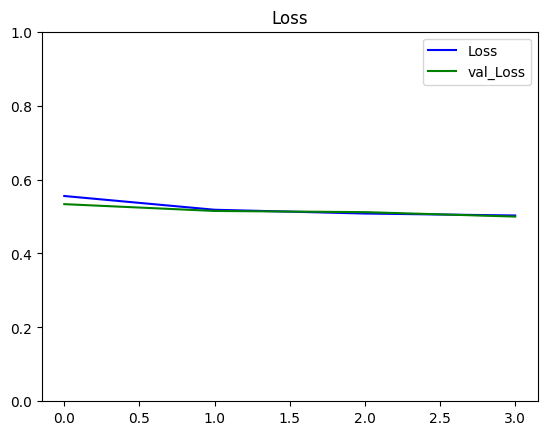

In [29]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(train_metric, color="blue", label=metric_name)
    if val_metric is not None:
        plt.plot(val_metric, color="green", label="val_" + metric_name)
    plt.legend(loc="upper right")


# plot loss history
plot_metrics(
    history.history["loss"], history.history["val_loss"], "Loss", "Loss", ylim=1.0
)

In [32]:
# get recommendations

# prepare data for inference
doc_features_infer = []
query_features_infer = []
query_doc_features_infer = []
query_infer = []
item_infer = []

for user in tqdm(test_user_id_list):
    df_train_mod_sub = df_train_mod[df_train_mod["user_id"] == user]
    df_train_mod_product_id = df_train_mod_sub["product_id"].unique()
    for product in df_train_mod_product_id:
        doc_features_infer.append(algo.qi[trainset.to_inner_iid(product)])
        query_features_infer.append(algo.pu[trainset.to_inner_uid(user)])
        query_doc_features_infer.append(
            np.concatenate(
                (
                    algo.qi[trainset.to_inner_iid(product)],
                    algo.pu[trainset.to_inner_uid(user)],
                )
            )
        )
        query_infer.append(user)
        item_infer.append(product)

df_RankNet_infer = pd.DataFrame(
    {
        "query_id": query_infer,
        "item_id": item_infer,
        "doc_features": doc_features_infer,
        "query_features": query_features_infer,
        "query_doc_features": query_doc_features_infer,
    }
)


100%|██████████| 1000/1000 [00:19<00:00, 50.57it/s]


In [41]:
recommendations_pred_RankNet = []
num_users = 500  # TODO it was done for increasing speed of the code, but it should be removede later

for user in tqdm(test_user_id_list[:num_users], leave=False):
    df_RankNet_test_sub = df_RankNet_infer[
        df_RankNet_infer["query_id"] == user
    ].reset_index()
    train_product_id_list_sorted = bubble_sort(df_RankNet_test_sub, ranknet)
    train_product_id_list_sorted = train_product_id_list_sorted[:n_rec]
    recommendations_pred_RankNet.append(train_product_id_list_sorted)

In [42]:
y_pred_RankNet = y_true["user_id"].iloc[:num_users]
y_pred_RankNet = pd.DataFrame(y_pred_RankNet)
y_pred_RankNet["y_pred"] = pd.DataFrame(
    recommendations_pred_RankNet).values.tolist()
y_pred_RankNet.head(10)


,user_id,y_pred
0,1,"[12427.0, 13176.0, 41787.0, 17122.0, 25133.0]"
1,2,"[32139.0, 24852.0, 47209.0, 37646.0, 22829.0]"
2,5,"[43693.0, 26604.0, 8518.0, 40706.0, 21413.0]"
3,7,"[4945.0, 40852.0, 32177.0, 13198.0, 17638.0]"
4,8,"[32030.0, 28985.0, 24838.0, 21903.0, 2078.0]"
5,9,"[5194.0, 40571.0, 33754.0, 38159.0, 4957.0]"
6,10,"[9339.0, 47380.0, 27156.0, 40604.0, 20995.0]"
7,13,"[4210.0, 27086.0, 1689.0, 27435.0, 31372.0]"
8,14,"[29509.0, 46979.0, 13966.0, 23803.0, 8744.0]"
9,17,"[7350.0, 17762.0, 16486.0, 7026.0, 48544.0]"


In [43]:
y_true.iloc[:10]


,user_id,y_true
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."
5,9,"[27555, 42347, 27596, 8834, 26604, 12075, 8467..."
6,10,"[29650, 48720, 24654, 10177]"
7,13,"[27435, 27086, 4210, 47078, 19934]"
8,14,"[11042, 32115, 28601, 29615, 15869, 37434, 380..."
9,17,"[18534, 1217, 12720, 16797, 43352, 4374]"


### 4.8.1 Evaluation

In [44]:
get_scores(y_true.iloc[:num_users], y_pred_RankNet, k=3)


hit_rate_at_k 0.584 
mean_average_precision_at_k 0.4316666666666667 
ndcg_at_k 0.2686378992367694


# 5. Results

n_users = 1000

Algorithm Name | MAP@k | HitRate@k | NDCG@k | Time fit [c] | Time predict [c]
---------------|:------|:----------|:-------|:------|:------
Most Popular| 0.1270 | 0.1270 | 0.0577 | 1.4 | 0.7
SVD| 0.1280 | 0.0935 | 0.0478 | 368 | 320
Neural Network| 0.0220 | 0.0127 | 0.0064 | 4646 | 1832
Nearest Neighbor| - | - | - | - | -
ALS| - | - | - | - | -
Gradient Boosting| - | - | - | - | -
The Pointwise Approach Associative Rules| 0.3283 | 0.3750 | 0.2279 | 50 | 9
The Pairwise Approach* 500 users| 0.4317 | 0.5840 | 0.2686 | 4967 | 1540